In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm.notebook import tqdm

# Loading the data

In [2]:
df = pd.read_csv("data.csv")

In [3]:
labels = df.values[:, 0]
reps = df.values[:, 1:]
xs = reps[:, 0:100]
ys = reps[:, 100:200]
zs = reps[:, 200:300]
runs = np.dstack((xs, ys, zs)).reshape((10, 10, 100, 3))

In [4]:
runs.shape

(10, 10, 100, 3)

# Visualizing the data

In [58]:
def plot_path(paths):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    for path, c in zip(paths, ["blue", "orange"]):
        ax.plot3D(path[:, 0], path[:, 1], path[:, 2], c=c)
        
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    plt.axis("equal")
    plt.show()

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

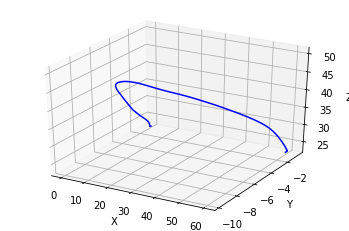

In [59]:
plot_path([runs[0, 0, :]])

In [60]:
mean_runs_for_rep = runs.mean(axis=0) # Take mean across people = compare rep 1 for per 1 with rep 1 for per 2
mean_runs_for_per = runs.mean(axis=1)# Take mean across repetitions = compare rep 1 for per 1 with rep 2 for per 1
mean_run = runs.mean(axis=(0,1))

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

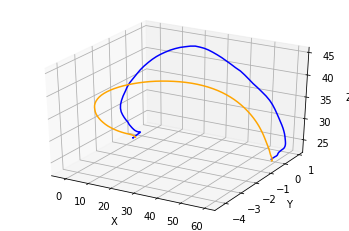

In [61]:
plot_path([runs[2, 0, :], mean_run])

In [8]:
run_residuals = runs - mean_run

NameError: name 'mean_run' is not defined

In [9]:
from scipy import interpolate

In [10]:
runs.shape

(10, 10, 100, 3)

NameError: name 'mean_run' is not defined

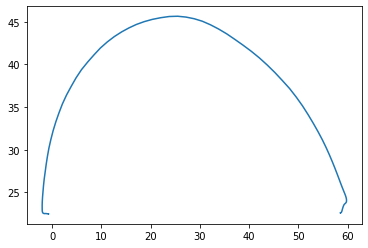

In [11]:
fig = plt.figure()
ax = plt.axes()
#ax.plot(xs, f(xs))
ax.plot(runs[2, 0, :, 0], runs[2, 0, :, 2])
ax.plot(mean_run[:, 0], mean_run[:, 2])
plt.show()

In [12]:
xs = np.linspace(0, 59, 100)

f1 = interpolate.interp1d(runs[2, 0, :, 0], runs[2, 0, :, 2], kind = "linear")
f2 = interpolate.interp1d(mean_run[:, 0], mean_run[:, 2], kind = "linear")

NameError: name 'mean_run' is not defined

NameError: name 'f2' is not defined

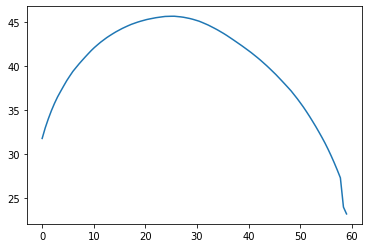

In [13]:
fig = plt.figure()
ax = plt.axes()
ax.plot(xs, f1(xs))
ax.plot(xs, f2(xs))
#ax.plot(run_residuals[2, 0, :, 2] + 1)
plt.show()

In [14]:
runs[2, 0, :, 0].max()

59.7771698484064

NameError: name 'f2' is not defined

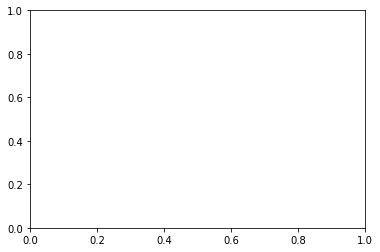

In [15]:
fig = plt.figure()
ax = plt.axes()
ax.plot(xs, f1(xs) - f2(xs))
#ax.plot(run_residuals[2, 0, :, 2] + 1)
plt.show()

In [16]:
import torch
import torch.nn as nn
import torch.functional as F

In [17]:
class MySuperModel(nn.Module):
    def __init__(self, c1=16, c2=32):
        super(MySuperModel, self).__init__()
        self.l0 = nn.Conv1d(3, 8, kernel_size=1) # 3 coordinates * 2
        
        # ResBlock 1
        self.l1_1 = nn.Conv1d(8, c1, kernel_size=10)
        self.l1_2 = nn.Conv1d(c1, c1, kernel_size=1)
        
        # ResBlock 2
        self.l2_1 = nn.Conv1d(c1, c2, kernel_size=10)
        self.l2_2 = nn.Conv1d(c2, c2, kernel_size=1)
        
        # Final linear layer
        self.fc1 = nn.Linear(c1 + c2, 16)
        self.fc2 = nn.Linear(16, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X):
        a0 = self.l0(X)
        
        # ResBlock 1
        a1 = self.l1_1(a0)
        #a1 = torch.cumsum(a1, dim=2)
        b1 = torch.relu(a1)
        c1 = self.l1_2(b1)
        d1 = a1 + c1
        
        # ResBlock 2
        a2 = self.l2_1(d1)
        #a2 = torch.cumsum(a2, dim=2)
        b2 = torch.relu(a2)
        c2 = self.l2_2(b2)
        d2 = a2 + c2
    
        
        
        # Last fully connected model
        a3 = torch.cat((d2[:, :, -1], d1[:, :, -1]), dim=1)
        b3 = self.fc1(a3)
        c3 = torch.relu(b3)
        d3 = self.fc2(c3)
        out = self.softmax(d3)
        
        return out

In [18]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype=np.uint8)[y]

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
X = torch.Tensor(runs).reshape((100, 3, -1))
Y = torch.Tensor(to_categorical(labels.astype(np.int8) - 1, 10))

In [21]:
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import scipy.stats as st

In [22]:
K1 = 10
K2 = 10

outer = KFold(n_splits=K1, shuffle=True, random_state=1337)
inner = KFold(n_splits=K2, shuffle=True, random_state=0xdeadbeef)

gen_errors = np.zeros((K1, 4)) # Baseline, KNN, DTC, ANN
params = np.zeros((K1, 4))


true_ys = []
pred_base_ys = []
pred_knn_ys = []
pred_dtc_ys = []
pred_ann_ys = []
    
for split, (data_indices, val_indices) in enumerate(outer.split(X)):
    print("Outer split: {}".format(split + 1))
        
    X_data, Y_data = X[data_indices], Y[data_indices]
    X_val, Y_val = X[val_indices], Y[val_indices]
    
    # Used for ANN
    # Send data to GPU (or CPU if we dont have one)
    X_data, Y_data = X_data.to(device), Y_data.to(device)
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    
    # Used for Decision Tree Classifier and KNN
    reps_data, labels_data = reps[data_indices], labels[data_indices]
    reps_val, labels_val = reps[val_indices], labels[val_indices]
    
    true_ys.append(labels_val)
    
    # Baseline
    base_line = DummyClassifier(strategy='uniform', random_state=0)
    base_line.fit(reps_data, labels_data)
    pred = base_line.predict(reps_val)
    pred_base_ys.append(pred) # Use for McNemar
    error = (pred != labels_val).mean()
    gen_errors[split, 0] = error
    
    
    # KNN and Decision Tree Classifier
    nns = np.arange(2, 15, 1)
    ts = np.arange(2, 25, 1)
    
    knn_test_errors = np.zeros((K2, len(nns)))
    dct_test_errors = np.zeros((K2, len(ts)))
    
    for split2, (train_indices, test_indices) in enumerate(inner.split(reps_data)):
        reps_train, labels_train = reps_data[train_indices], labels_data[train_indices]
        reps_test, labels_test = reps_data[test_indices], labels_data[test_indices]
        
        for i, l in enumerate(nns):
            knn = KNeighborsClassifier(n_neighbors=l)
            knn.fit(reps_train, labels_train)
            
            pred = knn.predict(reps_test)
            test_error = (pred != labels_test).mean()
            knn_test_errors[split2, i] = test_error * len(reps_test)
            
        
        for i, t in enumerate(ts):
            # Fit decision tree classifier, Gini split criterion, different pruning levels
            dtc = tree.DecisionTreeClassifier(criterion="gini", max_depth=t)
            dtc.fit(reps_train, labels_train)

            pred = dtc.predict(reps_test)
            test_error = (pred != labels_test).mean()
            dct_test_errors[split2, i] = test_error * len(reps_test)
        
        
      
    knn_gen_errors = (knn_test_errors / len(reps_data)).sum(axis=0)
    best_nn = nns[np.argmin(knn_gen_errors)]
    best_knn = KNeighborsClassifier(n_neighbors=best_nn)
    best_knn.fit(reps_data, labels_data)
    pred = best_knn.predict(reps_val)
    pred_knn_ys.append(pred) # Use for McNemar
    gen_error = (pred != labels_val).mean()
    gen_errors[split, 1] = gen_error
    params[split, 1] = best_nn
    
        
    dct_gen_errors = (dct_test_errors / len(reps_data)).sum(axis=0)
    best_t = ts[np.argmin(dct_gen_errors)]
    best_dtc = tree.DecisionTreeClassifier(criterion="gini", max_depth=best_t)
    best_dtc.fit(reps_data, labels_data)
    pred = best_dtc.predict(reps_val)
    pred_dtc_ys.append(pred) # Use for McNemar
    gen_error = (pred != labels_val).mean()
    gen_errors[split, 2] = gen_error
    params[split, 2] = best_t
    
    
    # Train neural network
    mySuperModel = MySuperModel(c1=64, c2=128).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(lr=1e-3, params=mySuperModel.parameters())
    
    for i in tqdm(range(0, 30_000)):
        optimizer.zero_grad()
        y_pred = mySuperModel(X_data)
        loss = criterion(y_pred, Y_data)
        loss.backward()
        optimizer.step()
    
    y_pred = mySuperModel(X_val)
    pred = y_pred.argmax(dim=1).cpu().numpy() + 1
    pred_ann_ys.append(pred)
    error = (pred != labels_val).mean()
    gen_errors[split, 3] = error

Outer split: 1



Outer split: 2



Outer split: 3



Outer split: 4



Outer split: 5



Outer split: 6



Outer split: 7



Outer split: 8



Outer split: 9



Outer split: 10


In [23]:
gen_errors

array([[1. , 0.6, 0.5, 0.2],
       [0.8, 0.2, 0.4, 0.2],
       [0.9, 0.4, 0.4, 0.3],
       [0.9, 0.4, 0.5, 0.2],
       [0.7, 0.4, 0.5, 0.6],
       [0.9, 0.2, 0. , 0.1],
       [0.9, 0.4, 0.4, 0.2],
       [1. , 0.6, 0.6, 0.7],
       [0.9, 0.4, 0.3, 0.5],
       [1. , 0.3, 0.7, 0.3]])

In [24]:
pred_ann_ys

[array([ 1,  2,  5,  5,  6,  7,  6,  8,  9, 10]),
 array([2, 2, 2, 4, 4, 6, 6, 7, 9, 9]),
 array([ 1,  2,  7,  4,  7,  7,  8,  8,  9, 10]),
 array([2, 7, 4, 5, 5, 5, 8, 8, 8, 9]),
 array([ 1,  4, 10,  2,  3,  2, 10,  6,  6,  6]),
 array([1, 6, 3, 4, 5, 5, 7, 8, 8, 9]),
 array([ 1,  2,  3,  4,  5,  5,  7,  4,  5, 10]),
 array([ 1,  5, 10,  2, 10,  2,  9,  8,  8, 10]),
 array([9, 1, 1, 7, 3, 3, 7, 8, 9, 2]),
 array([ 3,  6,  3,  3,  9,  9,  9, 10, 10, 10])]

[array([ 1.,  2.,  5.,  5.,  6.,  6.,  8.,  8.,  9., 10.]),
 array([2., 2., 4., 4., 4., 5., 6., 7., 9., 9.]),
 array([ 1.,  2.,  3.,  4.,  6.,  6.,  8.,  8.,  9., 10.]),
 array([2., 3., 4., 5., 5., 5., 6., 8., 8., 9.]),
 array([1., 1., 2., 2., 3., 4., 4., 6., 7., 7.]),
 array([1., 2., 3., 4., 5., 5., 7., 8., 8., 9.]),
 array([ 1.,  2.,  3.,  4.,  5.,  5.,  7., 10., 10., 10.]),
 array([ 1.,  2.,  3.,  6.,  6.,  7.,  7.,  7.,  8., 10.]),
 array([ 1.,  1.,  1.,  3.,  3.,  3.,  6.,  7.,  9., 10.]),
 array([ 3.,  4.,  7.,  8.,  9.,  9.,  9., 10., 10., 10.])]

In [26]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    # perform McNemars test
    nn = np.zeros((2,2))
    c1 = yhatA - y_true == 0
    c2 = yhatB - y_true == 0

    nn[0,0] = sum(c1 & c2)
    nn[0,1] = sum(c1 & ~c2)
    nn[1,0] = sum(~c1 & c2)
    nn[1,1] = sum(~c1 & ~c2)

    n = sum(nn.flat);
    n12 = nn[0,1]
    n21 = nn[1,0]

    thetahat = (n12-n21)/n
    Etheta = thetahat

    Q = n**2 * (n+1) * (Etheta+1) * (1-Etheta) / ( (n*(n12+n21) - (n12-n21)**2) )

    p = (Etheta + 1) * (Q-1)
    q = (1-Etheta) * (Q-1)

    CI = tuple(lm * 2 - 1 for lm in scipy.stats.beta.interval(1-alpha, a=p, b=q) )

    p = 2*scipy.stats.binom.cdf(min([n12,n21]), n=n12+n21, p=0.5)
    print("Result of McNemars test using alpha=", alpha)
    print("Comparison matrix n")
    print(nn)
    if n12+n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=",(n12+n21))

    print("Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = ", CI)
    print("p-value for two-sided test A and B have same accuracy (exact binomial test): p=", p)

    thetahat = 2*thetahat-1
    return thetahat, CI, p

In [30]:
from itertools import chain
import scipy

In [35]:
# McNemar test
print("KNN vs DTC")
ytrue = np.concatenate(true_ys)
dy1 = flatten_list = list(chain.from_iterable(pred_knn_ys))
dy2 = flatten_list = list(chain.from_iterable(pred_dtc_ys))
alpha = 0.05
[thetahat, CI, p] = mcnemar(ytrue, dy1, dy2, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p) 

print("DTC vs BASE")
dy1 = flatten_list = list(chain.from_iterable(pred_dtc_ys))
dy2 = flatten_list = list(chain.from_iterable(pred_base_ys))
alpha = 0.05
[thetahat, CI, p] = mcnemar(ytrue, dy1, dy2, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p) 

print("KNN vs BASE")
dy1 = flatten_list = list(chain.from_iterable(pred_knn_ys))
dy2 = flatten_list = list(chain.from_iterable(pred_base_ys))
alpha = 0.05
[thetahat, CI, p] = mcnemar(ytrue, dy1, dy2, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p) 

print("ANN vs BASE")
dy1 = flatten_list = list(chain.from_iterable(pred_ann_ys))
dy2 = flatten_list = list(chain.from_iterable(pred_base_ys))
alpha = 0.05
[thetahat, CI, p] = mcnemar(ytrue, dy1, dy2, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p) 

print("ANN vs KNN")
dy1 = flatten_list = list(chain.from_iterable(pred_ann_ys))
dy2 = flatten_list = list(chain.from_iterable(pred_knn_ys))
alpha = 0.05
[thetahat, CI, p] = mcnemar(ytrue, dy1, dy2, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p) 

print("ANN vs DTC")
dy1 = flatten_list = list(chain.from_iterable(pred_ann_ys))
dy2 = flatten_list = list(chain.from_iterable(pred_dtc_ys))
alpha = 0.05
[thetahat, CI, p] = mcnemar(ytrue, dy1, dy2, alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p) 


#box_data = [KNN_test_error,DT_test_error,base_line_test_err]

# Multiple box plots on one Axes
#fig, ax = plt.subplots()
#ax.boxplot(box_data)
#ax.set_title('Boxplot Comparison of Machine Learning Models')
#ax.set_xlabel('KNN                    D Tree                   Baseline')
#ax.set_ylabel('Classification Error Rate')
#plt.show()






KNN vs DTC
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[45. 16.]
 [12. 27.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.03289624422977677, 0.11268645249087172)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.571588188409805
theta = theta_A-theta_B point estimate -0.92  CI:  (-0.03289624422977677, 0.11268645249087172) p-value 0.571588188409805
DTC vs BASE
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[ 6. 51.]
 [ 4. 39.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.38898836130980174, 0.5472726135789372)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 2.0474233419776072e-11
theta = theta_A-theta_B point estimate -0.06000000000000005  CI:  (0.38898836130980174, 0.5472726135789372) p-value 2.0474233419776072e-11
KNN vs BASE
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[ 9. 52.]
 [ 1. 38.]]
Approximate 1-alpha confi

In [33]:
gen_errors

array([[1. , 0.6, 0.5, 0.2],
       [0.8, 0.2, 0.4, 0.2],
       [0.9, 0.4, 0.4, 0.3],
       [0.9, 0.4, 0.5, 0.2],
       [0.7, 0.4, 0.5, 0.6],
       [0.9, 0.2, 0. , 0.1],
       [0.9, 0.4, 0.4, 0.2],
       [1. , 0.6, 0.6, 0.7],
       [0.9, 0.4, 0.3, 0.5],
       [1. , 0.3, 0.7, 0.3]])

In [37]:
gen_errors.mean(axis=0)

array([0.9 , 0.39, 0.43, 0.33])

In [34]:
params

array([[ 0.,  3., 13.,  0.],
       [ 0.,  3., 13.,  0.],
       [ 0.,  8., 11.,  0.],
       [ 0.,  3., 19.,  0.],
       [ 0.,  6., 10.,  0.],
       [ 0.,  3.,  8.,  0.],
       [ 0.,  2.,  9.,  0.],
       [ 0.,  2., 13.,  0.],
       [ 0.,  2., 11.,  0.],
       [ 0.,  3., 18.,  0.]])

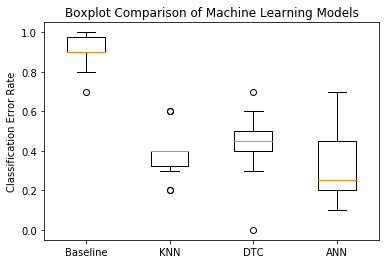

In [50]:
box_data = gen_errors

plt.boxplot(box_data)
labels = ('Baseline', 'KNN', 'DTC', 'ANN')
plt.xticks(np.arange(len(labels))+1,labels)
plt.title('Boxplot Comparison of Machine Learning Models')
plt.ylabel('Classification Error Rate')
plt.show()
